<a href="https://colab.research.google.com/github/davidsjohnson/xai_ac_sose25/blob/main/notebooks/exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI for Affective Computing (SoSe2025)
# Exercise 3:  Explanations for Images of Facial Expressions (SoSe2025)

In this notebook you will attempt to generate explanations for predictions of a facial expression recognition (FER) CNN trained on raw image data, using a subset of the [AffectNet dataset](http://mohammadmahoor.com/affectnet/). AffectNet is an image dataset of facial expressions in the wild, and is labeled with 8 facial expression categories: **Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, and Contempt**. (Have a look at the paper for more details https://arxiv.org/abs/1708.03985).


To generate explanations, you will use a variety of approaches including LIME, SHAP, Anchors and GradCAM. More information is provided throughout the noteobok.

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

***NOTE**: This notebook runtime could be improved by using a GPU if available.*

## Notebook Setup

Make sure to set to Colab flag below before running the code based on the environment you are using.

If you are running the notebook locally make sure to update the python packages by running `pip install -r requirements.txt` at the command line

In [1]:
colab = False # set to True if running in Google Colab or False if running locally

In [2]:
if colab:
  !git clone https://github.com/davidsjohnson/xai_ac_sose25.git

fatal: destination path 'xai_ac_sose25' already exists and is not an empty directory.


In [3]:
import sys
import os

if colab:
  sys.path.append(os.path.realpath('xai_ac_sose25'))
else:
  sys.path.append(os.path.realpath('../'))

In [4]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import utils
import img_utils
import models
import evaluate

In [5]:
base_dir = Path('../data/') if not colab else Path('xai_ac_sose25/data/')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# download the AffectNet dataset extracted features and a sample set of images for visualization
affnet_dir = utils.download_file('https://uni-bielefeld.sciebo.de/s/EmfF9r93LG4jcT9/download',
                          file_name='affectnet_data.zip',
                          cache_dir=base_dir,
                          extract=True,
                          force_download=False,     # set to False if you have already downloaded the dataset
                          archive_folder='affectnet_data')
affnet_dir

File already exists at: xai_ac_sose25/data/affectnet_data.zip


PosixPath('xai_ac_sose25/data/affectnet_data')

## XAI for FER with  Convoluational Neural Nets

### Setup the Pytorch Data Loader

In [7]:
#class labels
class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

# Setup XAI Data from AffectNet Deep Learning Model
TRAIN_MEAN = [0.485, 0.456, 0.406]
TRAIN_STD = [0.229, 0.224, 0.225]

# trainsform to preprocess the images
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    transforms.Resize((224, 224))
])

# set up and load the dataset
data_dir = base_dir / 'affectnet_data/affectnet/val_class'
dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)
images = [Image.open(f[0]).convert('RGB').resize((224,224)) for f in dataset.imgs] # load images as PIL objects and resize them
images = [np.array(img) / 255.0 for img in images] # convert to numpy arrays and rescale for display
y_true = np.array([f[1] for f in dataset.imgs])
y_labels = [class_names[f[1]] for f in dataset.imgs]
dataloader = DataLoader(dataset, batch_size=80, shuffle=False)

### Load Pretrained Model

In [8]:
# download checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/0tAa2wPhGxSDjbM/download'
ckpt_path = utils.download_file(ckpt_link,
                                'affectnet.pth',
                                cache_dir= base_dir / 'affectnet/model',
                                extract=False, # checkpoint is not a zip file
                                force_download=False
                                )
ckpt_path

File already exists at: xai_ac_sose25/data/affectnet/model/affectnet.pth


PosixPath('xai_ac_sose25/data/affectnet/model/affectnet.pth')

In [9]:
model = models.ResNet18(n_classes=len(class_names), pretrained=True)
model.to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval();

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


### Evaluation of Model

This model performs much better than the AU dataset, but still with only around $60\%$ accuracy.  But this is pretty close the state-of-the-art for the AffectNet dataset

In [10]:
inverse_weights = torch.from_numpy(1.0/np.array([74874, 134415, 25459, 14090, 6378, 3803, 24882, 3750])).type(torch.float32).to(device)
loss = torch.nn.CrossEntropyLoss(weight=inverse_weights)
_, _, y_preds, probs = evaluate.evaluate_model(model, dataloader, loss, device=device)

y_preds = np.array(y_preds)
# validate predictions and true values
(y_preds == y_true).mean()

Evaluation Loss: 1.3183, Evaluation Accuracy: 0.5875


0.5875

In [11]:
# eval results
print(classification_report(y_true, y_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.41      0.70      0.52        10
       Happy       0.82      0.90      0.86        10
         Sad       0.56      0.50      0.53        10
    Surprise       0.86      0.60      0.71        10
        Fear       0.57      0.40      0.47        10
     Disgust       0.78      0.70      0.74        10
       Anger       0.40      0.40      0.40        10
    Contempt       0.50      0.50      0.50        10

    accuracy                           0.59        80
   macro avg       0.61      0.59      0.59        80
weighted avg       0.61      0.59      0.59        80



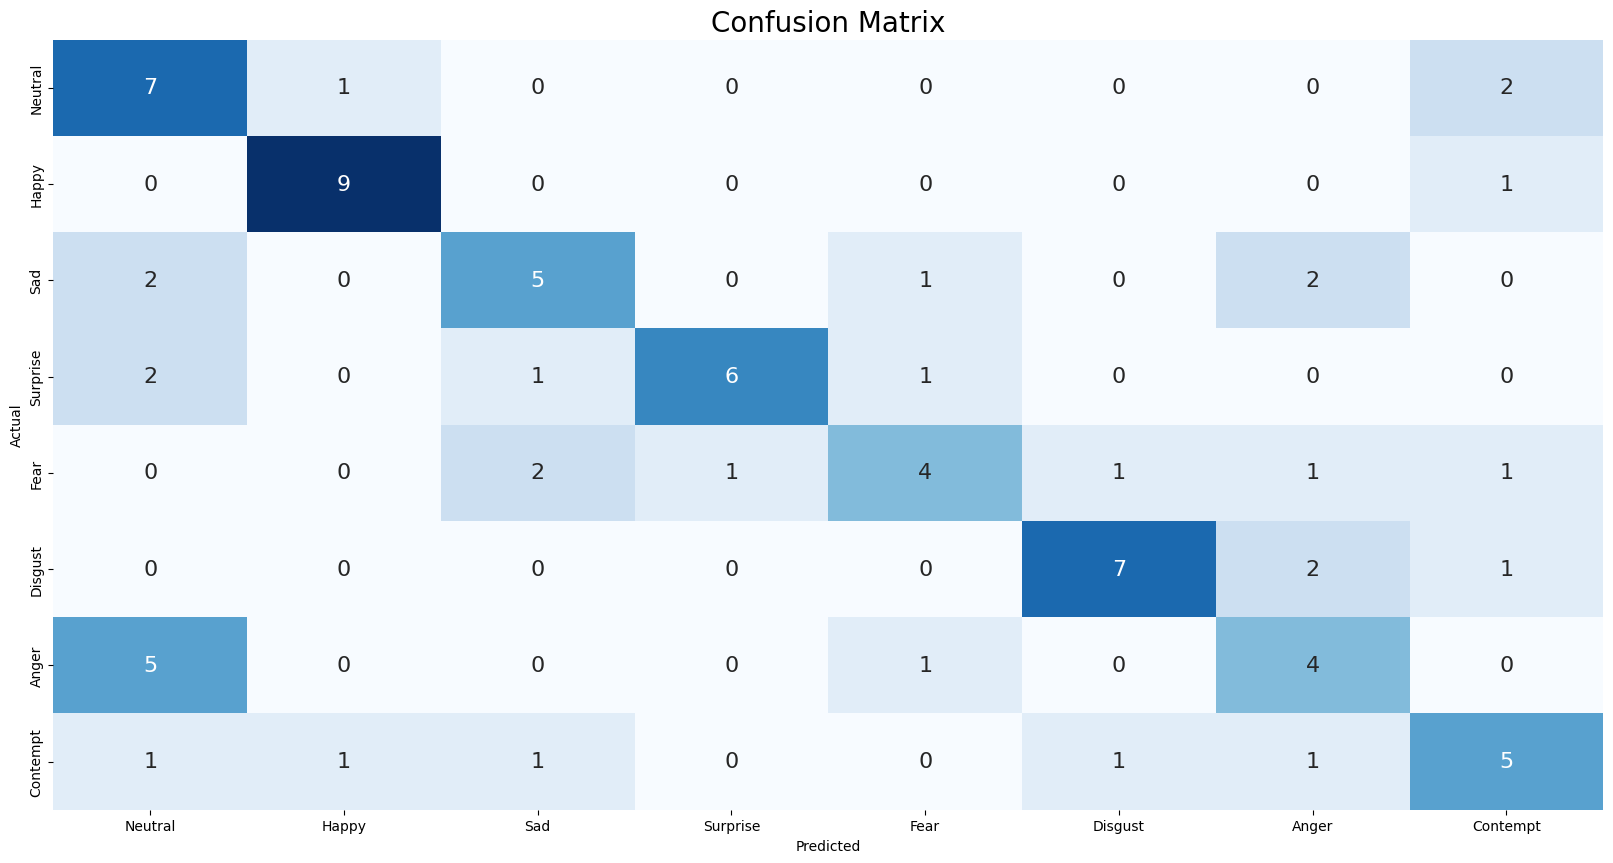

In [12]:
cm_data = confusion_matrix(y_true, y_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Generate Explanations

In [13]:
if colab:
  %pip install -q shap
  %pip install -q lime
  %pip install -q alibi
  %pip install -q grad-cam

### Task 1: Generate Local Explanations with LIME

In this task, you will use LIME to generate explanations from the CNN model provided above. In the last exercise, you learned about LIME and used it with tabular data.  Now you will use with a model that takes images as input. Review the [LIME paper](https://dl.acm.org/doi/10.1145/2939672.2939778) to better understand how LIME adapts its model simplification approach to images.  

LIME requires images to be segmented into superpixels.  For facial expressions the segmentation algorithm is very important and the default of the `explain_instance()` method may not provide good explanations.  Experiment with different segmenters using the LIME `SegmentationAlgorithm` class and pass to `segmenter_fn` argument of the `explain_instance()` method.

- For example: `segmenter = SegmentationAlgorithm('method name', params)`, where params are defined by the skimage segmentation alorithm method
- by default LIME uses:

```python
segmenter = SegmentationAlgorithm('quickshift', kernel_size=4,
                                  max_dist=200, ratio=0.2,
                                  random_seed=random_seed)
```

You can find different algorithms via [skimage segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html)


#### Completing the Task
- Before getting started with LIME, select 6 image that you want to gain explanations for. Choose 3 correct and 3 incorrect explanations. We will use the same images in the following tasks.

- Then, Implement a [LimeImageExplainer](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image) instance, you can review the [LIME tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb) for help.
- Next, implement and visualize the segment boundaries for the default LIME segmenter and at least one other segementation algorithm. You should also alter some of the various hyperpameters for each algorithm to find an approach you feel works best.  Choose the algorithm and hyperparameters which you think are best for generating a LIME explanation on facial expression recognition.
- Now generate and visualize the explanations for each of you selected images. Experiment with the default segmenter and another segmenter as found above in task 2.2a


Hint: to quickly display images with a title, you can use the function `img_utils.display_one_image`. The function takes three inputs, an image, a title and a subplot tuple in the form (nrows, ncols, current_index). The subplot tuple allows you to plot multiple images in one plot similar to matplotlib

In [14]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from skimage.segmentation import mark_boundaries # used to get boundries from explanation for plotting

**Preview the Dataset with Predictions**

The code below will display images from the XAI dataset.
- Try changing value of `start` to get a new set of images (there are 10 images for each class; for example, the class happy will be at indexes 10-19)
- Search through the images to find some that might be interesting to Explain

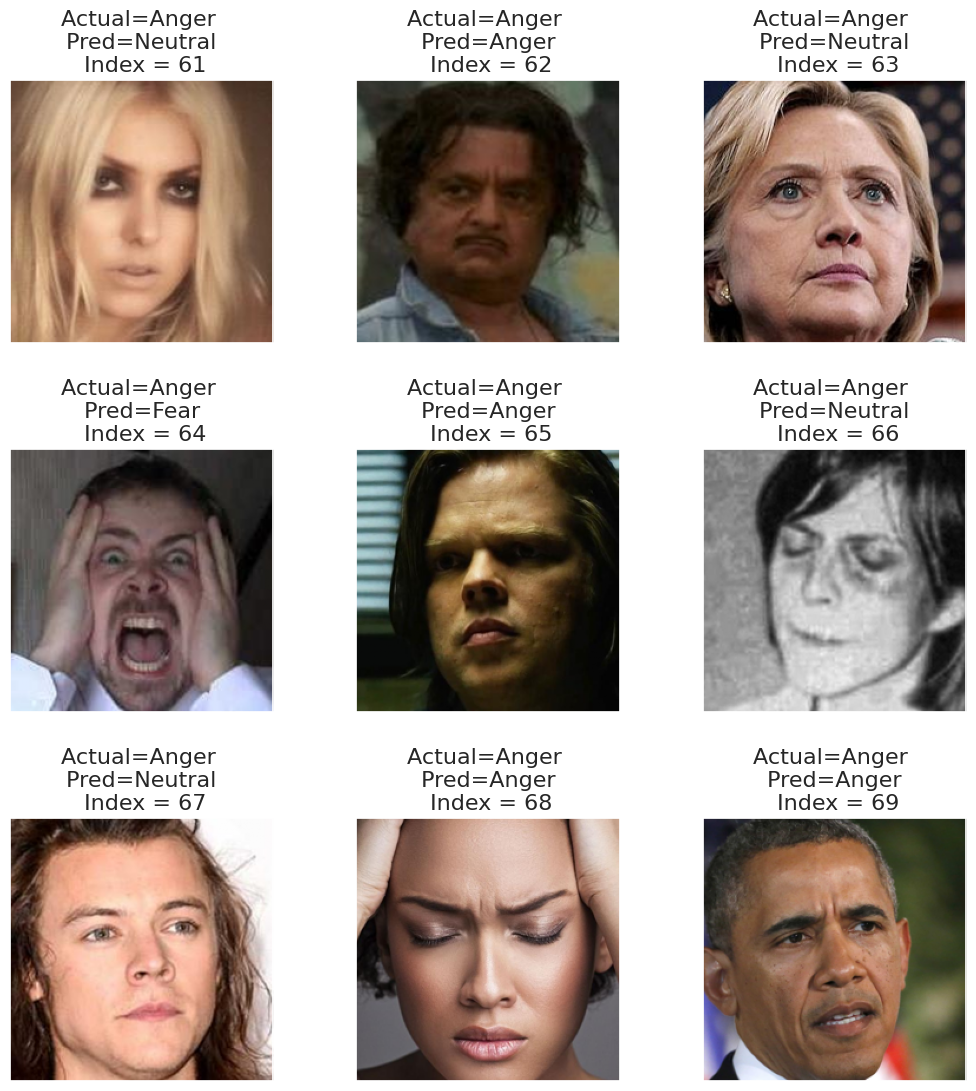

In [15]:
start=61
img_utils.display_nine_images(images, y_true, y_preds, start)

In [16]:
####### Select Your images #######
##################################

img_idxs_corr = []
img_idxs_incorr = []

all_idxs = img_idxs_corr + img_idxs_incorr

In [17]:
# model wrapper for lime
def f(x):
    tensors = []
    pil_images = [Image.fromarray((img * 255).astype(np.uint8)).convert('RGB') for img in x]
    for img in pil_images:
      out = test_transform(img)
      tensors.append(out)
    tensors = torch.stack(tensors).to(device)
    with torch.no_grad():
        y = model(tensors)
    return F.softmax(y, dim=1).cpu().numpy()

In [18]:
##### YOUR CODE GOES HERE #####
###############################


### Task 2 - Generate Local Explanations with Anchor

In this task you will generate explanations for the images using a rule-based approach called Anchor. The method is based on the paper [Anchors: High-Precision Model-Agnostic Explanations, Ribero et al. 2018](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) and from the same authors as LIME.  

The approach builds on LIME's approach on model simplification, but instead of find the most important features, it aims to find an input's "Anchor". An anchor is a rule that is sufficent for the prediction, such that changes to other features have no effect on the model output.  See the above paper for a more in depth description.  

To implement, Anchors we will use the python package [Alibi](https://docs.seldon.io/projects/alibi/en/stable/index.html). Alibi, also, has a [good description of the Anchors approach](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html).

#### To complete the tasks

- Use the same images defined in the LIME task
- Also, use the same segmentation algorithm and parameters defined in the LIME task.  
- Create an AnchorImage explainer and generate Anchors for each of your selected images. See the [Anchors tutorial](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) for details.  
- Visualize each of the Anchor explanations.  Make sure to include the ground truth value and the prediction when displaying the images.  

In [19]:
from alibi.explainers import AnchorImage

In [20]:
##### YOUR CODE GOES HERE #####
###############################


### Task 3: General Local Explanations with SHAP

In this task, you will generate [SHAP-based explanations](https://shap.readthedocs.io).  You will use the basic SHAP partition explainer which is a model-agnostic approach to generating explanations. See the ["Explain ResNet50 ImageNet using Partition Explainer"](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html) example for detail on how to implement it.  

Altough, the example is for Tensorflow, the main idea stays the same.  You will need a `masker` and a `model` wrapper that takes an array of raw images, applies the image transform and returns the probabilities for each image.

Note: since AffectNet images are all different resolutions, I've included code to resize all the images before sending to SHAP. Thie makes it easier to deal with all images at once (rather than looping).

#### To complete this task:

- Use the same images from the previous tasks.
- Implement a function that wraps the pytorch model to allow for input in the form of raw images as numpy arrays, and outputs the model predictions.  Remember to use the `test_transform` on the images to apply normalization.  
- Then, generate a SHAP explainer, initialized with the wrapper function and a masker. You may want to experiment with different types of maskers.  
- Finally, generate and visualize the SHAP explanations for each image.  The visualization should be similar to the example from the tutorial. This means you should plot the saliency maps in the order of their prediction probabilities (but for all classes not just the first 4).


In [21]:
import shap

In [22]:
# resize images so they all can be explained together
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ToPILImage()
])
images_resized = np.array([transform(x) for x in images])

In [23]:
##### YOUR CODE GOES HERE #####
###############################



### Task 4 - Generate Local Explanations with GradCAM

In this task, you generate Gradient-Weighted Class Activation Maps (GradCAM) explanations for the images.  GradCAM is another commonly used feature-based approach and was popularized with the paper [Grad-CAM:
Visual Explanations from Deep Networks via Gradient-based Localization](https://ieeexplore.ieee.org/document/8237336). The main idea of GradCAM is use use the gradients of a target output to create a weighted sum of activation maps from the final layer in the network. This generates a course localization of important regions of the input image for a specified output.  

For this task, you will use the [`pytorch-grad-cam` python package](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html)


#### To complete this task:

- Use the same images from the previous tasks.
- Review the [grad-cam introduction](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) for details on implementing grad-cam using this package.
- Implement a standard GradCAM explainer for the last layer of the network. Provided in the below code in the variable `target_layers`.
- For the images that were correctly predicted by the network, visualize the GradCAM output for the predicated class.
- For the images that were incorrectly predicted by the network, visualize both the explanations for the prediction and the ground truth.  

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [25]:
###### Enter your Code Below ######
##################################


### Task 5: Discuss your findings.

For this task, you will answer the following questions regarding your experiences with the above XAI approaches.

1. You used four explanation techniques: LIME, SHAP, Anchors, and GradCAM. Explain the main differences in the techniques and how this affects the interpretation of the output explanations.
2. Which explanation method produced the most intuitive result for you? Why do you think it was easier to interpret?
3. Were there any explanation methods that produced results that surprised you or seemed incorrect? What might be the reason?
4. Imagine you are building a real-world system that uses facial expressions for mental health assessment, like the recognition of social anxiety. Which explanation method would you use to justify your model’s decision to an end user (e.g., a psychologist)? How would you visualize or communicate the explanation?

Write your answers here...